<a href="https://colab.research.google.com/github/LoganRoth/greeneyes/blob/master/recycing_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# Set up drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Training on GPU


In [0]:
# Set up use of GPU
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
  print('Training on GPU')
else:
  print('Training on CPU')

In [0]:
# Load Data

from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
data_dir = '/content/drive/My Drive/Capstone/Technical/Training Images/garbage-classification/Garbage classification/Garbage classification'
test_dir = '/content/drive/My Drive/Capstone/Technical/Testing Images'

transforms_set = transforms.Compose([
    transforms.CenterCrop(384),
    transforms.Resize(266),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

test_transforms_set = transforms.Compose([   
    transforms.CenterCrop(384),
    transforms.Resize(266),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

batch_size = 20
test_size = 0.10
val_size = 0.20

data = datasets.ImageFolder(data_dir, transform=transforms_set)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms_set)
indices = list(range(len(data)))
np.random.shuffle(indices)
num_total = len(data)
test_split = int(np.floor(test_size * num_total))
train_indices, test_idx = indices[test_split:], indices[:test_split]
num_train = len(train_indices)
val_split = int(np.floor(val_size * num_train))
train_idx, valid_idx = train_indices[val_split:], train_indices[:val_split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

trainloader = torch.utils.data.DataLoader(data, batch_size=batch_size,
    sampler=train_sampler)
validloader = torch.utils.data.DataLoader(data, batch_size=batch_size,
    sampler=valid_sampler)
testloader = torch.utils.data.DataLoader(data, batch_size=batch_size,
    sampler=test_sampler)
finaltestloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

classes = data.classes
num_classes = len(data.classes)

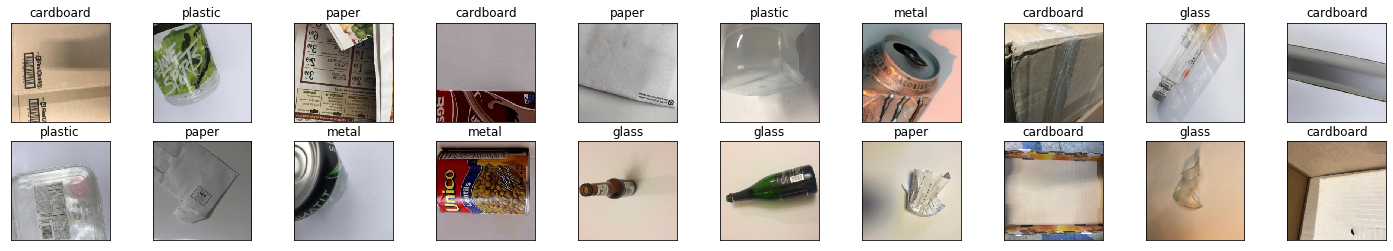

In [18]:
# See the images
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0))) 

# obtain one batch of training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [0]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 266x266x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 11)  # -> 256x256x16
        # convolutional layer (sees 256x256x16 tensor)
        self.conv2 = nn.Conv2d(16, 64, 3, padding=1)  # -> 256x256x64
        # convolutional layer (sees 64x64x64 tensor)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)  # -> 64x64x128
        # convolutional layer (sees 16x16x128 tensor)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)  # -> 16x16x256
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # max pooling layer
        self.pool4 = nn.MaxPool2d(4, 4)
        # linear layer (256 * 8 * 8 -> 800)
        self.fc1 = nn.Linear(256 * 8 * 8, 800)
        # linear layer (800 -> 6)
        self.fc2 = nn.Linear(800, 7)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = F.relu(self.conv1(x))
        x = self.pool4(F.relu(self.conv2(x)))
        x = self.pool4(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        # flatten image input
        x = x.view(-1, 256 * 8 * 8)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu and add dropout layer
        x = self.dropout(F.relu(self.fc1(x)))
        # add 2nd hidden layer, with relu
        x = self.fc2(x)
        return x

In [0]:
# define the CNN architecture
# 94% - 100%
class BestSoFarNet(nn.Module):
    def __init__(self):
        super(BestSoFarNet, self).__init__()
        # convolutional layer (sees 266x266x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 11)  # -> 256x256x16
        # convolutional layer (sees 64x64x64 tensor)
        self.conv2 = nn.Conv2d(16, 64, 3, padding=1)  # -> 64x64x64
        # convolutional layer (sees 16x16x64 tensor)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)  # -> 16x16x128
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # max pooling layer
        self.pool4 = nn.MaxPool2d(4, 4)
        # linear layer (128 * 8 * 8 -> 500)
        self.fc1 = nn.Linear(128 * 8 * 8, 500)
        # linear layer (500 -> 6)
        self.fc2 = nn.Linear(500, 7)
        # dropout layer (p=0.15)
        self.dropout = nn.Dropout(0.15)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool4(F.relu(self.conv1(x)))
        x = self.pool4(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 128 * 8 * 8)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu and add dropout layer
        x = self.dropout(F.relu(self.fc1(x)))
        # add 2nd hidden layer, with relu
        x = self.fc2(x)
        return x

# define the CNN architecture
# 89% - 100%
class OtherBestNet(nn.Module):
    def __init__(self):
        super(OtherBestNet, self).__init__()
        # convolutional layer (sees 266x266x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 11)  # -> 256x256x16
        # convolutional layer (sees 256x256x16 tensor)
        self.conv2 = nn.Conv2d(16, 64, 3, padding=1)  # -> 256x256x64
        # convolutional layer (sees 64x64x64 tensor)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)  # -> 64x64x128
        # convolutional layer (sees 16x16x128 tensor)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)  # -> 16x16x256
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # max pooling layer
        self.pool4 = nn.MaxPool2d(4, 4)
        # linear layer (256 * 8 * 8 -> 800)
        self.fc1 = nn.Linear(256 * 8 * 8, 800)
        # linear layer (800 -> 6)
        self.fc2 = nn.Linear(800, 7)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = F.relu(self.conv1(x))
        x = self.pool4(F.relu(self.conv2(x)))
        x = self.pool4(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        # flatten image input
        x = x.view(-1, 256 * 8 * 8)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu and add dropout layer
        x = self.dropout(F.relu(self.fc1(x)))
        # add 2nd hidden layer, with relu
        x = self.fc2(x)
        return x

In [31]:
# create a complete CNN
model = OtherBestNet()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

OtherBestNet(
  (conv1): Conv2d(3, 16, kernel_size=(11, 11), stride=(1, 1))
  (conv2): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool4): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=800, bias=True)
  (fc2): Linear(in_features=800, out_features=7, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [0]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [23]:
# number of epochs to train the model
n_epochs = 60

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in trainloader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in validloader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(trainloader.sampler)
    valid_loss = valid_loss/len(validloader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), '/content/drive/My Drive/Capstone/Technical/recycle3.pth')
        valid_loss_min = valid_loss

KeyboardInterrupt: ignored

In [32]:
# Load the best model
model.load_state_dict(torch.load('/content/drive/My Drive/Capstone/Technical/recycle.pth'))

<All keys matched successfully>

In [0]:
def convert_to_my_classes(x):
    my_dict = [
        [1, 2, 5],  # blue
        [0, 4],  # grey
        [6],  # trash
        [3],  # green
    ]
    if x in my_dict[0]:
        return 0
    elif x in my_dict[1]:
        return 1
    elif x in my_dict[2]:
        return 2
    elif x in my_dict[3]:
        return 3

In [34]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))
my_class_correct = list(0. for i in range(4))
my_class_total = list(0. for i in range(4))
my_classes = ['blue', 'grey', 'trash', 'green']
correct = []

model.eval()
# iterate over test data
for data, target in testloader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    pred = pred.numpy() if not train_on_gpu else pred.cpu().numpy()
    targ = target.data.numpy() if not train_on_gpu else target.data.cpu().numpy()
    # compare predictions to true label
    for i in range(len(pred)):
        correct.append(convert_to_my_classes(pred[i]) == convert_to_my_classes(targ[i]))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        try:
            label = convert_to_my_classes(target.data[i])
            my_class_correct[label] += correct[i]
            my_class_total[label] += 1
        except IndexError:
            break

# average test loss
test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(4):
    if my_class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            my_classes[i], 100 * my_class_correct[i] / my_class_total[i],
            np.sum(my_class_correct[i]), np.sum(my_class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (my_classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(my_class_correct) / np.sum(my_class_total),
    np.sum(my_class_correct), np.sum(my_class_total)))

Test Loss: 0.042373

Test Accuracy of  blue: 88% (135/153)
Test Accuracy of  grey: 92% (89/96)
Test Accuracy of trash: 100% (12/12)
Test Accuracy of green: 75% ( 6/ 8)

Test Accuracy (Overall): 89% (242/269)


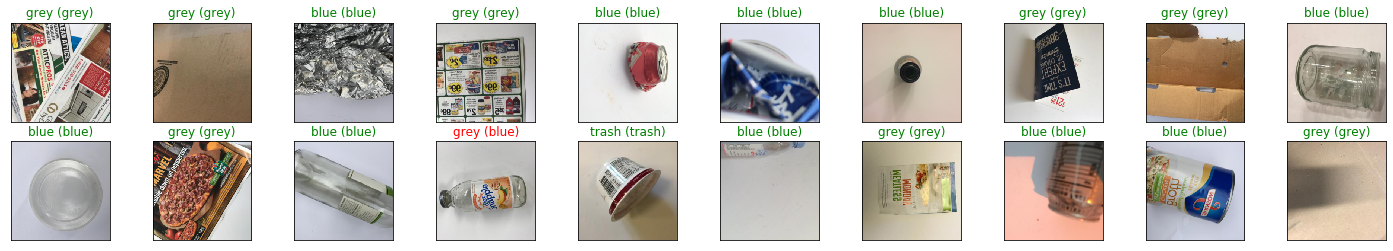

In [35]:
# obtain one batch of test images
dataiter = iter(testloader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
my_preds = []
my_labels = []
for i in range(len(preds)):
    my_preds.append(convert_to_my_classes(preds[i]))
    my_labels.append(convert_to_my_classes(labels[i]))

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(my_classes[my_preds[idx]], my_classes[my_labels[idx]]),
                 color=("green" if my_preds[idx]== my_labels[idx] else "red"))

In [36]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))
my_class_correct = list(0. for i in range(4))
my_class_total = list(0. for i in range(4))
my_classes = ['blue', 'grey', 'trash', 'green']
correct = []

model.eval()
# iterate over test data
for data, target in finaltestloader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    pred = pred.numpy() if not train_on_gpu else pred.cpu().numpy()
    targ = target.data.numpy() if not train_on_gpu else target.data.cpu().numpy()
    # compare predictions to true label
    for i in range(len(pred)):
        correct.append(convert_to_my_classes(pred[i]) == convert_to_my_classes(targ[i]))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        try:
            label = convert_to_my_classes(target.data[i])
            my_class_correct[label] += correct[i]
            my_class_total[label] += 1
        except IndexError:
            break

# average test loss
test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(4):
    if my_class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            my_classes[i], 100 * my_class_correct[i] / my_class_total[i],
            np.sum(my_class_correct[i]), np.sum(my_class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (my_classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(my_class_correct) / np.sum(my_class_total),
    np.sum(my_class_correct), np.sum(my_class_total)))

Test Loss: 0.016687

Test Accuracy of  blue: 100% (26/26)
Test Accuracy of  grey: 100% (22/22)
Test Accuracy of trash: 100% (10/10)
Test Accuracy of green: 100% ( 9/ 9)

Test Accuracy (Overall): 100% (67/67)


torch.Size([20, 3, 266, 266])
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>


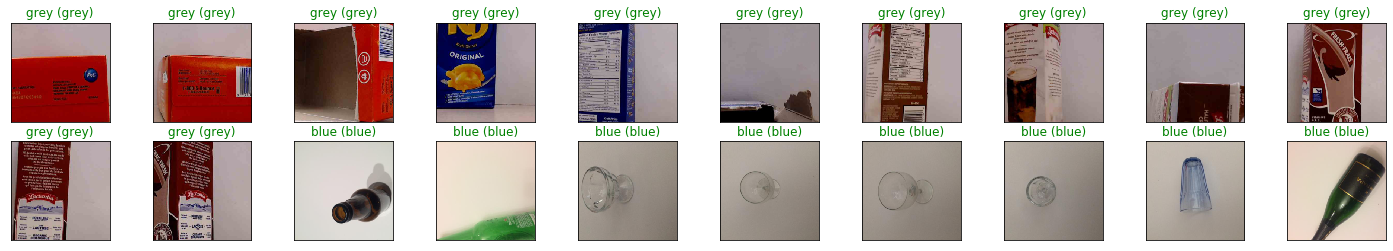

In [44]:
# obtain one batch of test images
dataiter = iter(finaltestloader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()
print(images.shape)
print(type(images))
# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
my_preds = []
my_labels = []
for i in range(len(preds)):
    my_preds.append(convert_to_my_classes(preds[i]))
    my_labels.append(convert_to_my_classes(labels[i]))

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(my_classes[my_preds[idx]], my_classes[my_labels[idx]]),
                 color=("green" if my_preds[idx]== my_labels[idx] else "red"))

images = images.cpu().numpy()
print(type(images))
images = torch.tensor(images).cuda()
print(type(images))